# Detector de estrellas candidatas a HVS
En este notebook, se quiere explorar el uso de las fuentes de datos necesarias para el trabajo fin de master *Detecting Intermediate Mass Black Holes in globular clusters using Gaia Home*. Dichas fuentes de datos son:
- Gaia DR3
- XMMNewton (3XMM-DR8 catalogue)
- Chandra (Chandra Source Catalogue-CSC-R2)

Otro objetivo de este notebook es obtener un punto de partida recreando los resultados expuestos en [Tracing black holes in globular clusters with Gaia](https://santiago-ucm.atlassian.net/wiki/spaces/IMBH/overview?homepageId=98423) usando los resultados de DR3 en vex de DR2.


Usaremos astropy  y astroquery para la explotación de las bases de datos. De manera adicional, para la obtención de las coordenadas de los cúmulos globulares usaremos el catálogo *Globular Cluster Systems of Galaxies Catalog* (GCSCAT) integrado en Heasarc. 

### Requirements

In [1]:
%load_ext autoreload
%autoreload 2


#@markdown ### Librerías y funciones auxiliares
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Añadir el directorio raíz del proyecto al sys.path
project_path = os.path.abspath(os.path.join(os.getcwd(), "../src"))  # Subir un nivel
if project_path not in sys.path:
    sys.path.append(project_path)
            

from hyper_velocity_stars_detection.jobs.project_vars import SELECTED_CLUSTERS, PATH
from hyper_velocity_stars_detection.etls.catalogs import CatalogsType
from hyper_velocity_stars_detection.astrobjects import AstroObjectProject
from hyper_velocity_stars_detection.jobs.cluster_selection_job import download_data
from hyper_velocity_stars_detection.tools.cmd_constructor import load_isochrone_from_parsec, cmd_plot, get_best_isochrone_fitted, cmd_with_cluster
from hyper_velocity_stars_detection.tools.cluster_detection import clustering_dbscan, cluster_representation_with_hvs, get_main_cluster

In [2]:
cluster = SELECTED_CLUSTERS[0]
project = download_data(cluster_name=cluster.name, path=PATH)

df_iso = None
distance_module = None
redding = None
print(str(project))

Las muestras analizadas de ngc 104 son:
Muestras seleccionadas del objeto astronómico r con radio 1:
	 - df_1_c0 - Todas las estrellas seleccionadas: 154362.
	 - df_1_c1 - Las estrellas con errores de paralaje y pm menores al 10%: 16353.
	 - df_1_c2 - Las estrellas con un error de paralaje menor del 30% y de pm menores al 10%: 16353.
	 - df_1_c3 - Las estrellas con un error de paralaje menor del 10% y de pm menores al 20%.: 24125.

Muestras seleccionadas del objeto astronómico r con radio 6:
	 - df_6_c0 - Todas las estrellas seleccionadas: 5444.
	 - df_6_c1 - Las estrellas con errores de paralaje y pm menores al 10%: 1898.
	 - df_6_c2 - Las estrellas con un error de paralaje menor del 30% y de pm menores al 10%: 1898.
	 - df_6_c3 - Las estrellas con un error de paralaje menor del 10% y de pm menores al 20%.: 2370.

Se han encontrado 1 fuentes de rayos X.



In [3]:
dfr1 = project.data_list[0].get_data("df_1_c3")
df_iso = load_isochrone_from_parsec("output258596335844.dat.txt")
distance_module, redding = get_best_isochrone_fitted(dfr1, df_iso)
distance_module, redding

/home/santhiperbolico/Documentos/UCM/tfm-ucm-code/src/hyper_velocity_stars_detection/tools/cmd_constructor.py:62: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_isochrone = pd.read_csv(


(np.float64(12.980589007466982), np.float64(-0.15561298168499949))

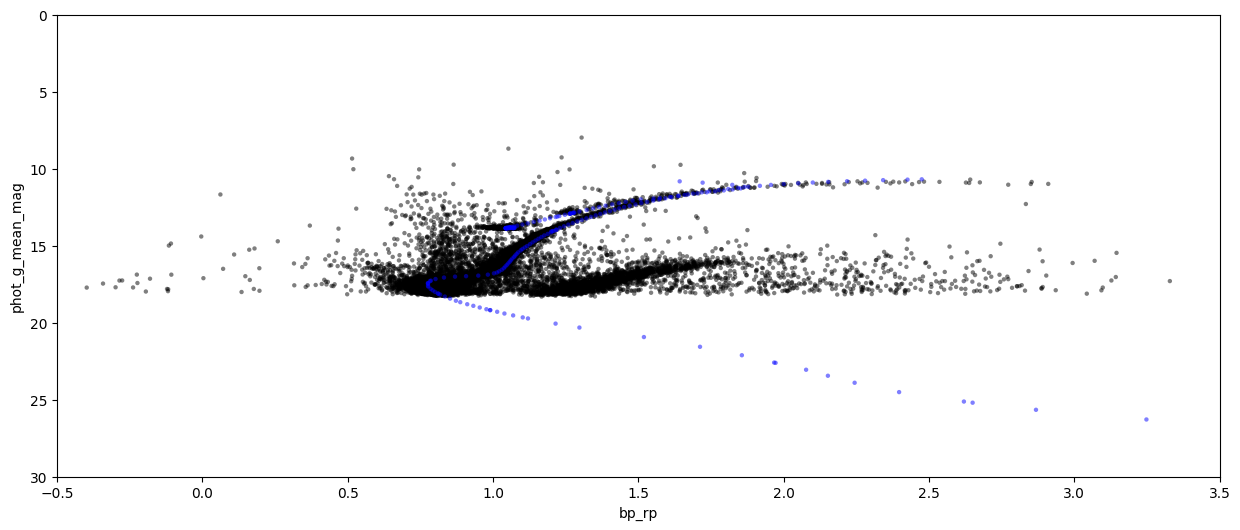

In [4]:
dfr1 = project.data_list[0].get_data("df_1_c3")

ax, fig = cmd_plot(dfr1, df_iso, isochrone_distance_module=distance_module, isochrone_redding=redding
                  )
ax.set_xlim(-0.5, 3.5)
ax.set_ylim(30, 0)
plt.show()

In [ ]:
columns_to_clus=["pmra", "pmdec", "parallax", 
                 'bp_rp', 
                 # 'phot_g_mean_mag'
                ]

labels = clustering_dbscan(
    df_stars=dfr1, 
    columns=["pmra", "pmdec", "parallax"], 
    columns_to_clus=columns_to_clus,
    max_cluster=10
)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

print("Volumen total del catálogo: %d" % df.shape[0])

for label in np.unique(labels[labels >-1]):
    mask_i = labels == label
    print(f"Volumen total del cluster {label}: %d" % mask_i.sum())

IndexError: Boolean index has wrong length: 21529 instead of 23684

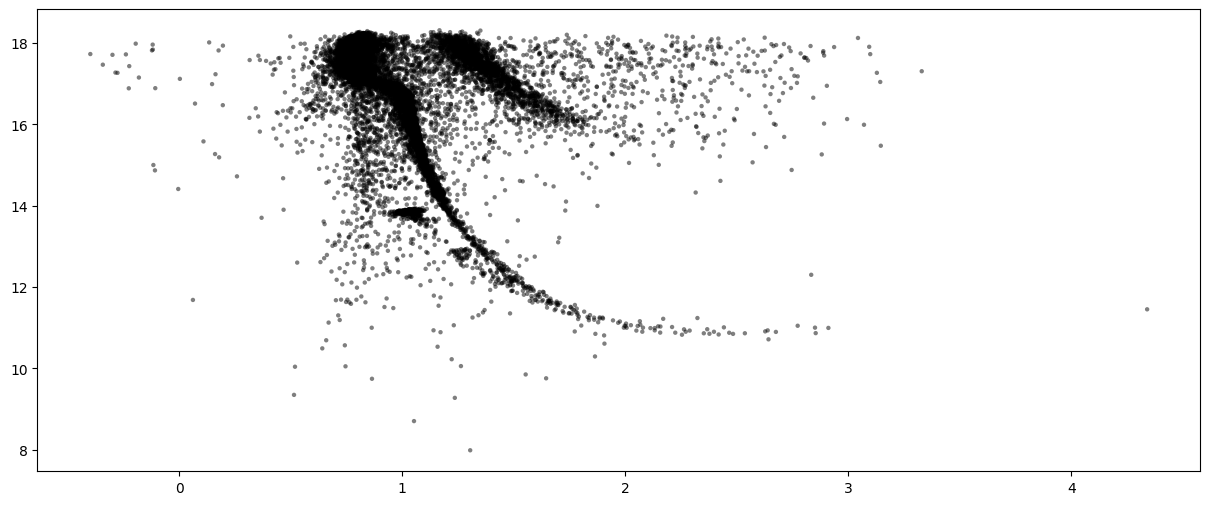

In [104]:
mask_nan = dfr1[columns_to_clus].isna().any(axis=1).values
data = dfr1[~mask_nan]

ax, fig = cmd_with_cluster(data, labels, df_iso, isochrone_distance_module=distance_module, isochrone_redding=redding
                          )
# ax.set_xlim(-0.5, 3.5)
# ax.set_ylim(30, 0)
plt.legend()
plt.show()

In [80]:
mask = labels == get_main_cluster(labels)
gc = data[mask]

print("Número de estrellas de CLuster seleccionado: %d" % gc.shape[0])
print("Número de HVS del CLuster seleccionado: %d" % gc[gc.pm_kms>200].shape[0])
display(gc[["pmra", "pmdec", "parallax"]].describe())

Número de estrellas de CLuster seleccionado: 15600
Número de HVS del CLuster seleccionado: 6213


,pmra,pmdec,parallax
count,15600.000000,15600.000000,15600.000000
mean,-4.936736,-4.261159,0.249057
std,2.805581,3.041270,0.158840
min,-16.922385,-8.834267,-0.398254
25%,-6.442710,-6.784178,0.141073
50%,-3.631905,-6.133139,0.204360
75%,-3.098570,-1.574727,0.341713
max,2.380923,5.492280,0.848062


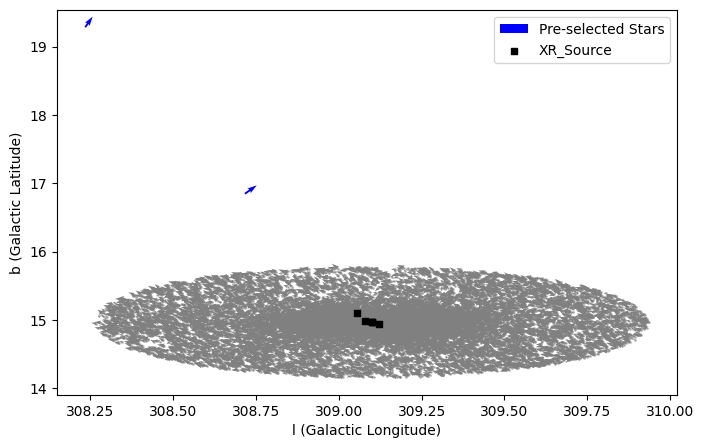

In [85]:
dfr6 = project.data_list[0].get_data("df_6_c2")

fig, ax = cluster_representation_with_hvs(data, dfr6, labels, hvs_pm=20, df_source_x=project.xsources)
plt.show()

## Referencias
- Kızıltan, B., Baumgardt, H., & Loeb, A. (2017). An intermediate-mass black hole in the centre of the globular cluster 47 Tucanae. Nature, 542(7640), 203-205.